<a href="https://colab.research.google.com/github/jlaurant/j/blob/master/surveyResults.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.style.use('ggplot')

## Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!ls '/content/drive/My Drive/DSI GA'

 AF
'ATD Information Session Registration.gform'
'Competitor Analysis - DSI'
'demo report'
'DSBA Alumni.csv'
'DSBA and HI Graduates 04_13_17.gsheet'
'DSBA and HI Graduates 04_13_17.xlsx'
'DSBA Student.csv'
'DSI Alumni'
'DSI Calendar.gsheet'
'dsi data'
 DSI_emailList_2019S.gsheet
 DSI_emailList_2019S.xlsx
'DSI GA Spring 2019 Work Schedule.gdoc'
'DSI GA Summer 2019 Work Schedule.gdoc'
'DSI Graduate Assistant Spring 2019 Schedule.docx'
'Fall DSBA Orientation & Townhall Reply Form.gform'
'Info Session Email Lists.gsheet'
'Info Session Email Lists.xls'
'UNCC DSI Alumni Survey.gform'
'Wells Fargo ettian group.gform'


In [0]:
# import data
alumni = pd.read_csv('/content/drive/My Drive/DSI GA/DSBA Alumni.csv',encoding = "ISO-8859-1")
student = pd.read_csv('/content/drive/My Drive/DSI GA/DSBA Student.csv',encoding = "ISO-8859-1")

In [8]:
alumni.columns

Index(['DSBA MS', 'DSBA Certificate', 'gradYear', 'expBefore', 'Finance',
       'Retail', 'Healthcare', 'Technology', 'Government/Military',
       'Research/Education', 'otherIndustry', 'employer', 'city', 'otherCity',
       'title', 'otherTitle', 'salary', 'promotion', 'helpful',
       'importantSkill', 'neglectedSkill', 'citizenBefore', 'returnOffer',
       'currentVisa', 'workUSin3yrs', 'age', 'gender',
       'Prefer to self-describe'],
      dtype='object')

In [0]:
text=alumni[['importantSkill','neglectedSkill']].append(student[['importantSkill','neglectedSkill']])

In [18]:
text.head()

,importantSkill,neglectedSkill
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,Pls add AWS and inferential statistics course
4,NaN,More coding experience


## K means Clustering

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

### challenge

In [44]:
challenge=text.neglectedSkill.dropna().as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [45]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(challenge)

true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind]),
    print

print("\n")


Top terms per cluster:
Cluster 0:
 analytics
 text
 skills
 think
 presentation
Cluster 1:
 python
 training
 hadoop
 programming
 seen
Cluster 2:
 learning
 spark
 scala
 deep
 hadoop
Cluster 3:
 data
 science
 mathematical
 courses
 statistics
Cluster 4:
 coding
 experience
 git
 etl
 added




## Topic modeling

### Text preparations

In [0]:
# Tokenize the text
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [26]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Get meaning of words and roots
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [0]:
# Get the stop words
en_stop = set(nltk.corpus.stopwords.words('english'))

In [0]:
# Wrap the whole thing into one package
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 2]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [48]:
print(challenge[0:5,])

['Pls add AWS and inferential statistics course' 'More coding experience'
 'spark , hadoop , ethics in DS'
 'Cloud , data modeling, data structures and algos'
 'Looks good in the current state.']


In [49]:
# import the data
import random
text_data = []

for row in challenge:
    tokens = prepare_text_for_lda(row)
    if random.random() > .02:
       print(tokens)
       text_data.append(tokens)

['pls', 'add', 'aws', 'inferential', 'statistics', 'course']
['coding', 'experience']
['spark', 'hadoop', 'ethics']
['cloud', 'data', 'modeling', 'data', 'structure', 'algos']
['look', 'good', 'current', 'state']
['programmatic', 'skill']
['presentation', 'skill']
['would', 'encourage', 'instruction', 'use', 'especially', 'real', 'world', 'hands', 'example', 'currently', 'working', 'text', 'document', 'would', 'found', 'exposure', 'nlp', 'nlu', 'helpful']
['introduce', 'big', 'data', 'tool', 'use', 'industry', 'expert', 'spark', 'dask']
['focus', 'open', 'source', 'data', 'science', 'also', 'discus', 'implement', 'data', 'science', 'model', 'real', 'life', 'end', 'end', 'flow', 'building', 'deploy', 'model']
['big', 'data', 'emphasis', 'cloud', 'base', 'technology', 'possible']
['text', 'analytics']
['cloud', 'computing', 'security', 'analytics']
['spark', 'scala']
['hadoop', 'scala']
['python']
['yes', 'heavy', 'python', 'programming', 'experience']
['python', 'hadoop', 'spark', 'trai

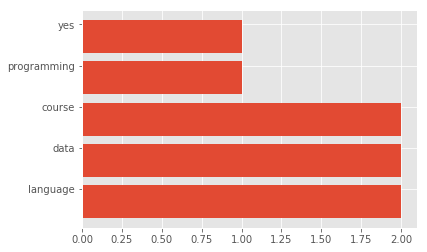

In [50]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
counts = dict(Counter(tokens).most_common(5))

labels, values = zip(*counts.items())

indSort = np.argsort(values)[::-1]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]

indexes = np.arange(len(labels))

## plot the frequncies
bar_width = 0.3

plt.barh(indexes, values)

plt.yticks(indexes + bar_width, labels)
plt.show()

### LDA

Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic. It builds a topic per document model and words per topic model, modeled as Dirichlet distributions. <br>
ref: http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/

In [53]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [58]:
import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=10)
ldamodel.save('model.gensim')
topics = ldamodel.print_topics(num_words=4)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [59]:
lda.show_topics()

[(0,
  '0.036*"learning" + 0.029*"deep" + 0.022*"network" + 0.022*"recognition" + 0.015*"statistics" + 0.015*"analytics" + 0.015*"cloud" + 0.015*"step" + 0.015*"generative" + 0.015*"image"'),
 (1,
  '0.030*"course" + 0.024*"would" + 0.024*"text" + 0.024*"data" + 0.018*"skill" + 0.018*"program" + 0.018*"science" + 0.018*"coding" + 0.018*"database" + 0.018*"analytics"'),
 (2,
  '0.076*"python" + 0.037*"class" + 0.031*"spark" + 0.029*"hadoop" + 0.024*"learning" + 0.024*"scala" + 0.024*"course" + 0.016*"yes" + 0.016*"depth" + 0.016*"see"'),
 (3,
  '0.056*"data" + 0.038*"statistics" + 0.020*"add" + 0.020*"science" + 0.020*"spark" + 0.020*"model" + 0.020*"inferential" + 0.020*"end" + 0.020*"course" + 0.011*"introduce"'),
 (4,
  '0.028*"course" + 0.028*"would" + 0.021*"data" + 0.015*"skill" + 0.014*"good" + 0.014*"language" + 0.014*"program" + 0.014*"processing" + 0.014*"employer" + 0.014*"one"')]

We can change num_topics, and save it as a new model, e.g. 'model10.gensim'. <br>
Later in the visualization part, change the model name accordingly.

### Visualize the LDA results

In [42]:
pip install pyldavis

     |████████████████████████████████| 1.6MB 2.9MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=e4079e0887b30f1402cf942547144d7c2122c109e91690155f3fdce7126620f1
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis


In [60]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model.gensim')

import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Saliency: a measure of how much the term tells you about the topic. <br>
Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.<br>
The size of the bubble measures the importance of the topics, relative to the data.

## Bar chart for the free form questions

#### Pre-processing the data 
Repace III and II and Sr with 'Senior' in excel!

In [0]:
text_plt=text.challenge.dropna().as_matrix()

In [0]:
# import the data
import random
word_list = []

for line in text_plt:
    tokens = prepare_text_for_lda(line)
    if random.random() > .50:
       word_list.append(tokens)

In [0]:
word_list[:7]

[['training'],
 ['beyond', 'analyst'],
 ['talented', 'individual', 'visa', 'issue'],
 ['finding', 'talent'],
 ['resource', 'right', 'blend', 'business', 'technology', 'skill']]

In [0]:
#titles = np.array([ elem for singleList in title_list for elem in singleList])
#print ("There are {} words in the combination of all titles.".format(len(titles)))

#### Using n-gram to get the essence of the titles

In [0]:
# combine the tokens together
word_list= [' '.join(i) for i in word_list]

In [0]:
word_list[:10]

['training',
 'beyond analyst',
 'talented individual visa issue',
 'finding talent',
 'resource right blend business technology skill']

In [0]:
# Python3 code to demonstrate Bigram formation 
# using list comprehension + enumerate() + split() 
   
# initializing list  
test_list = word_list
  
# using list comprehension + enumerate() + split() 
# for Bigram formation 
res = [(x, i.split()[j + 1]) for i in test_list  
       for j, x in enumerate(i.split()) if j < len(i.split()) - 1] 
  
# printing result 
print (res) 

[('beyond', 'analyst'), ('talented', 'individual'), ('individual', 'visa'), ('visa', 'issue'), ('finding', 'talent'), ('resource', 'right'), ('right', 'blend'), ('blend', 'business'), ('business', 'technology'), ('technology', 'skill')]


In [0]:
# remove elements if needes
res = [x for x in res if x != ('data','science')]

In [0]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
counts = dict(Counter(res).most_common(15))

labels, values = zip(*counts.items())

indSort = np.argsort(values)[::-1]

labels = np.array(labels)[indSort]
values = np.array(values)[indSort]
indexes = np.arange(len(labels))

In [0]:
labels= [' '.join(i) for i in labels]
print(labels)
print(values)
print(indexes)

['technology skill', 'business technology', 'blend business', 'right blend', 'resource right', 'finding talent', 'visa issue', 'individual visa', 'talented individual', 'beyond analyst']
[1 1 1 1 1 1 1 1 1 1]
[0 1 2 3 4 5 6 7 8 9]


In [0]:
indexes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

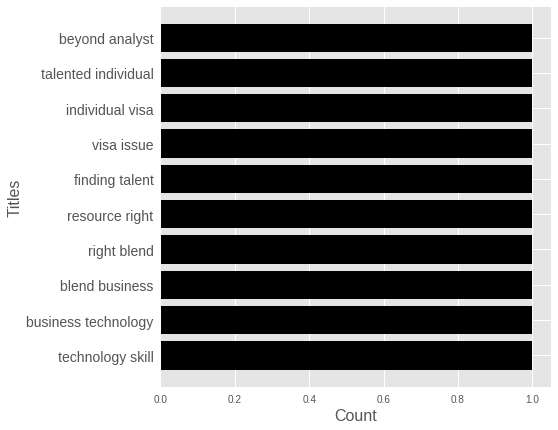

In [0]:
## plot the frequncies
from matplotlib.pyplot import figure
figure(1,[7,7])
plt.barh(indexes,values,color='k')
plt.xlabel('Count',size=16)
plt.ylabel('Titles',size=16)
plt.yticks(indexes,labels,size=14)
plt.show()